# Konnektor - NetworkGenerators
----------------------------------
In this Notebook we want to briefly describe all the present network layouts in Konnektor.
For understanding the functionalities in Konnektor, please checkout the example notebook.


In [ ]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -U https://github.com/conda-incubator/condacolab/archive/cuda-version-12.tar.gz
    import condacolab
    condacolab.install_mambaforge()
    !wget -q https://raw.githubusercontent.com/OpenFreeEnergy/konnektor/main/examples/environment.yaml
    !mamba env update -q --name=base --file=environment.yaml
    
from google.colab import output
output.enable_custom_widget_manager()

## Generating Randomized input data:
In this step randomized toy input is generated. Note they only work in combination with each other! A real world example can be found in the konnektor_example notebook.
Nevertheless, feel free to play with the parameters, `n_compounds` is steering the number of compounds, that should be used. the `rand_seed` can be used to always build the same random dataset.

In [1]:
from konnektor.visualization import draw_ligand_network

from konnektor.utils.toy_data import build_random_dataset

components, mapper, scorer = build_random_dataset(n_compounds=30, rand_seed=None)

## Star Network
The Star Network is one of the most edge efficient layouts, it basically places all `Transformations` around one central `Component`.

The algorithm constructs in a first step all possilbe `Transformations`. 
Next it selects in the default variant the in average best transformation score performing `Component` as the central component.
Finally all Components are connected with a `Transformation` to the central `Component`

The Star Netwrok is most edge efficient, but not most graph score efficient, as it has to find a central `Component`, which usually is a compromise for all 'Component's.
From a robustness point of view, the Star Network, will immediatly be disconnected if one `Transformation` fails. 
However the loss of `Component`s is very limited, as only one ligand is lost per `Transformation` failure.

In [2]:
from konnektor.network_planners import StarNetworkGenerator

ligand_network_planner = StarNetworkGenerator(
    mapper=mapper, scorer=scorer, n_processes=1
)

In [3]:
star_network = ligand_network_planner(components)
star_network.name = "Star Network"
star_network

<LigandNetwork-4121a1b88d3215595ca376784bf1b848>

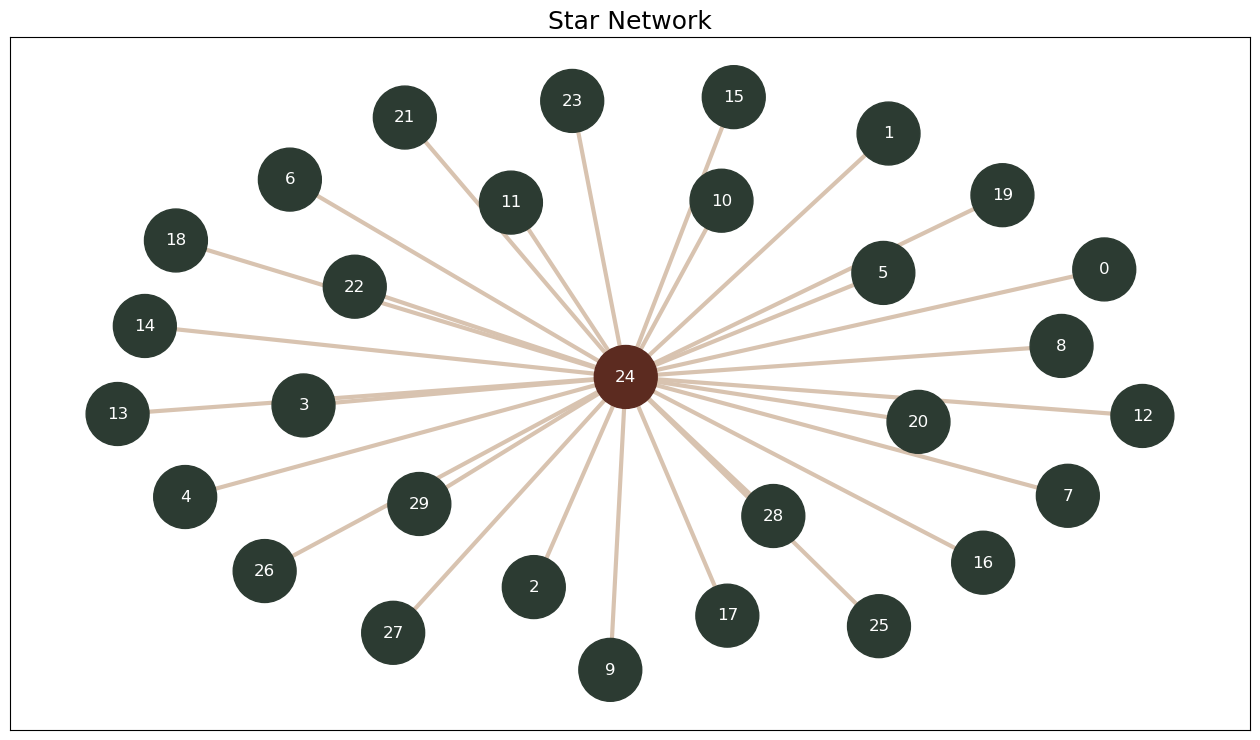

In [4]:
draw_ligand_network(network=star_network, title=star_network.name);

## Twin Star Network
The Twin Star Network is an expansion to the Star Network. It can be described as multiple star networks, that are overlayed. 

The algorithm is first calculating all possible `Transformation`s for all `Component`s. 
Next the in average `n_centers` (default: 2) best performing `Component`s over all transfromation scores are selected and placed into the center of the network.
Finally all components are connected to the selected centers, resulting in $n_{Transformations} = n_{centers}*(n_{Componentes}-n_{centers})$

This approach has in the default version the doubled number of `Transformations` compared to the Star Network and therefore also has an increase graph cost.
However on the plus side, this approach builds a lot graph cycles, which could be used to estimate the uncertainty of FE calculations.
Another important aspect is that the node connectivity is centralized around the `n_centers`. This means, 
that the selection of the central ligands is very important, as they have a large impact on the `Transformations`.
The `n_centers` option allows you to change the Twin Star to a Triplet Star Network or more.


In [5]:
from konnektor.network_planners import TwinStarNetworkGenerator

ligand_network_planner = TwinStarNetworkGenerator(
    mapper=mapper, scorer=scorer, n_centers=2
)

In [6]:
twin_star_network = ligand_network_planner(components)
twin_star_network.name = "Twin Star Network"
twin_star_network

<LigandNetwork-e35c54f9be6d3793c05c1e9941df5f8b>

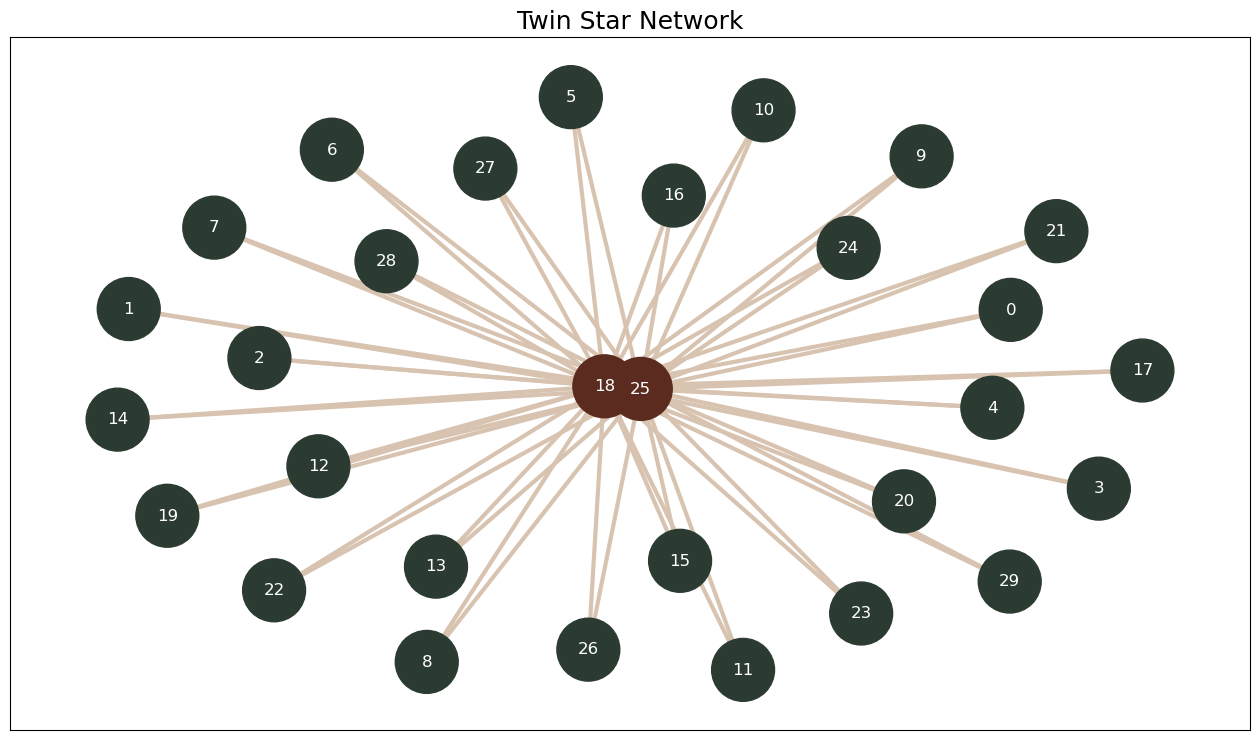

In [7]:
draw_ligand_network(network=twin_star_network, title=twin_star_network.name);

## Starry Sky Network
The StarrySkyNetworkGenerator is an advanced network algorithm,that clusters the provided `Component`s and builds up a network from this.

The approach follows the following steps:
1. Component clustering:
    1. Translate the Molecules into Morgan Fingerprints. (default)
    2. Cluster the Morgan Fingerprints with HDBSCAN. (default)
2. Build Sub-Star Networks in each Cluster using the `StarNetworkGenerator`.
3. Concatenate the Sub-Star Networks to the final Starry  Sky Network, with 3 `Transformations` per cluster pair using the `MSTConcatenator`.

This approach allows in comparison to the Star Network, to build a network containing multiple centers imopoving the graph score. Still adding a limited amount of `Transformation`s increasing the computational cost, but not as much `Transformations` as with the Twin Star Network would be generated. So the Starry Sky Network is a compromise betwen graph score optimization and number of `Transformations`.

In [8]:
from sklearn.cluster import HDBSCAN
from scikit_mol.fingerprints import MorganFingerprintTransformer
from konnektor.network_tools import ComponentsDiversityClusterer
from konnektor.network_planners import StarrySkyNetworkGenerator

ligand_network_planner = StarrySkyNetworkGenerator(
    mapper=mapper,
    scorer=scorer,
    clusterer=ComponentsDiversityClusterer(
        featurize=MorganFingerprintTransformer(),
        cluster=HDBSCAN(metric="jaccard", min_cluster_size=3, alpha=1 / 2048),
    ),
    n_processes=1,
)

In [9]:
starry_sky_network = ligand_network_planner(components)
starry_sky_network.name = "Starry Sky Network"
starry_sky_network

<LigandNetwork-8f612f1556c47a3c0bc55b625486f5f5>

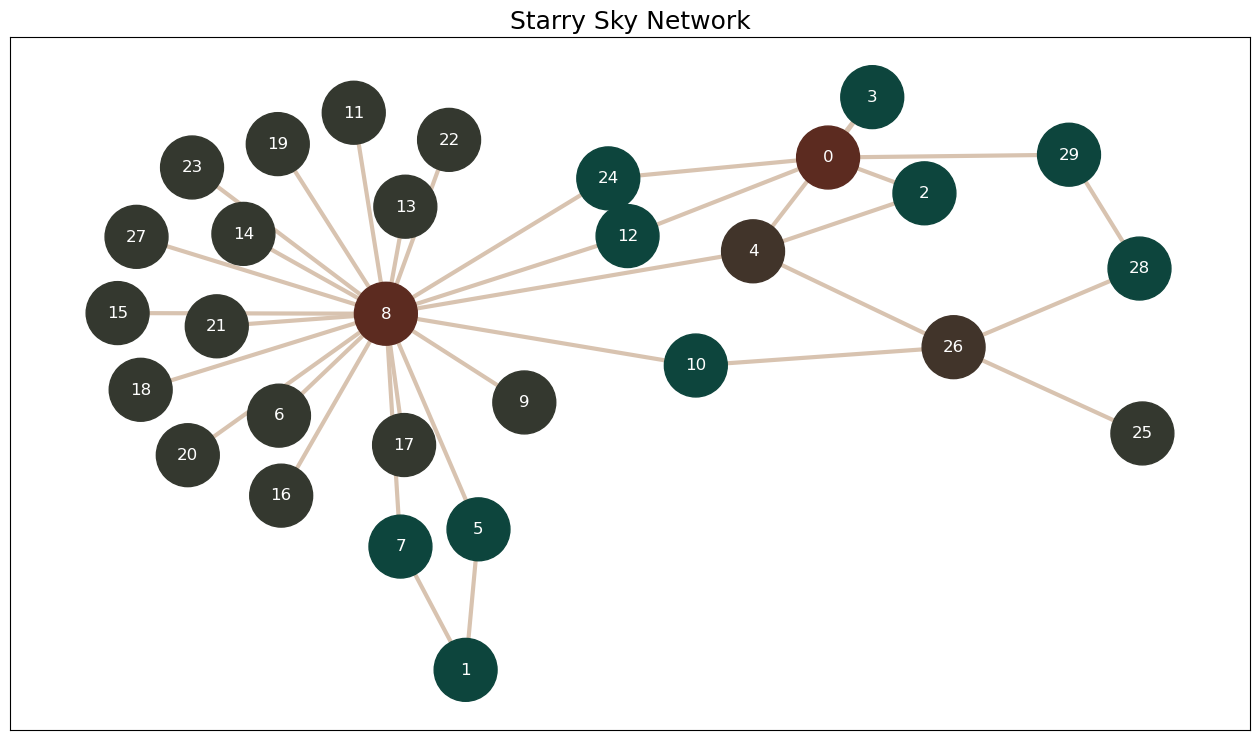

In [10]:
draw_ligand_network(network=starry_sky_network, title=starry_sky_network.name);

# Minimal Spanning Tree
The `MinimalSpanningTreeNetworkGenerator`, builds an minimal spanning tree (MST) network for a given set of `Component`s. The `Transformation`s of the Network,
are represented by an `AtomMapping`s, which are scored by a `AtomMappingScorer`. 

For the MST algorithm the Kruskal Algorithm is used.

The MST algorithm gives the optimal graph score possible and the minimal required set of `Transformations`. 
This makes the  MST Network very efficient. However, the MST is not very robust, in case of one failing `Transformation`, the Network is immediatly disconnected. 
The disconnectivity will translate to a loss of `Component`s in the final FE Network. 

In [11]:
from konnektor.network_planners import MinimalSpanningTreeNetworkGenerator

ligand_network_planner = MinimalSpanningTreeNetworkGenerator(
    mapper=mapper, scorer=scorer
)

In [12]:
mst_network = ligand_network_planner(components)
mst_network.name = "Min Spanning Tree Network"
mst_network

<LigandNetwork-dd49a19ac3f52054f8c05c73efcce389>

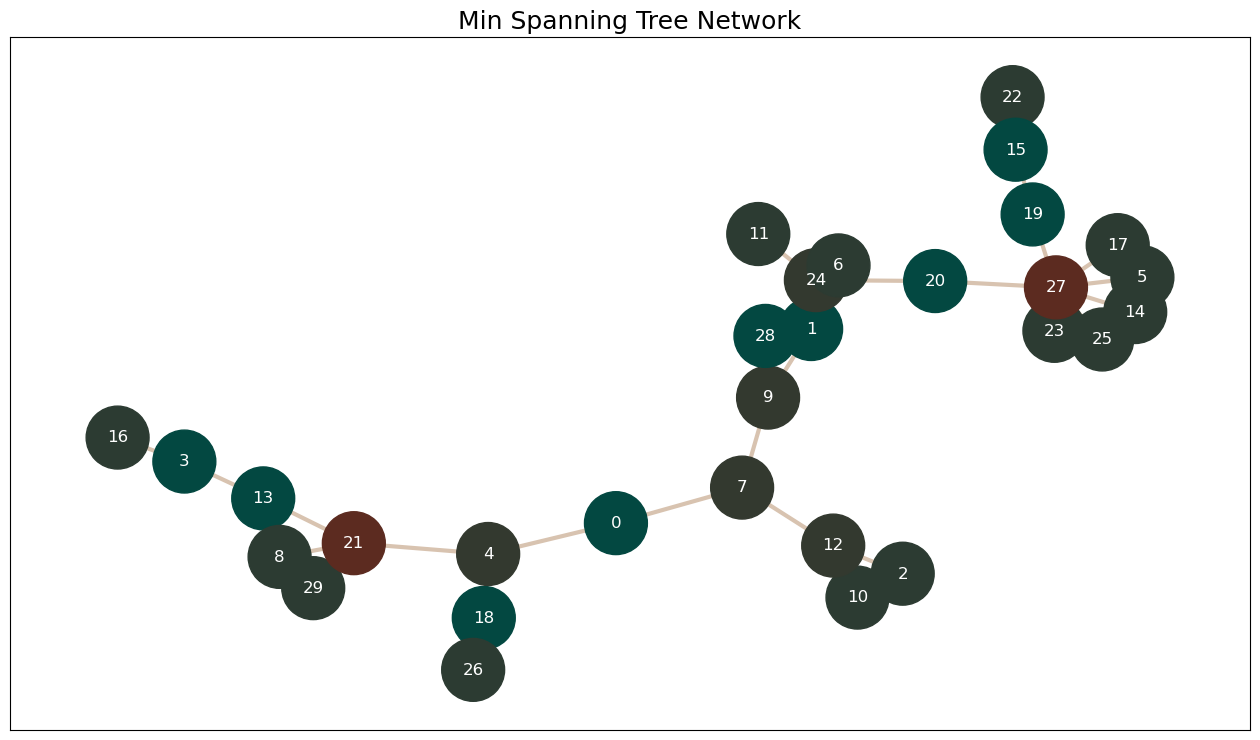

In [13]:
draw_ligand_network(network=mst_network, title=mst_network.name);

# N-Node Edges Network
The N-Node Edges Network tries to add more redundancy to the MST Network and tries to improve the robustness.

The algorithm first build a MST Network. 
After this it will add best score performing `Transformations` in order to guarantee a 'Component' connectivity of `target_node_connectivity`.

In [14]:
from konnektor.network_planners import NNodeEdgesNetworkGenerator

ligand_network_planner = NNodeEdgesNetworkGenerator(
    mapper=mapper, scorer=scorer, target_component_connectivity=3
)

In [15]:
nedges_network = ligand_network_planner(components)
nedges_network.name = "N-Edges Network"
nedges_network

<LigandNetwork-b9c16d3960e1bea6782bbc557f84a99f>

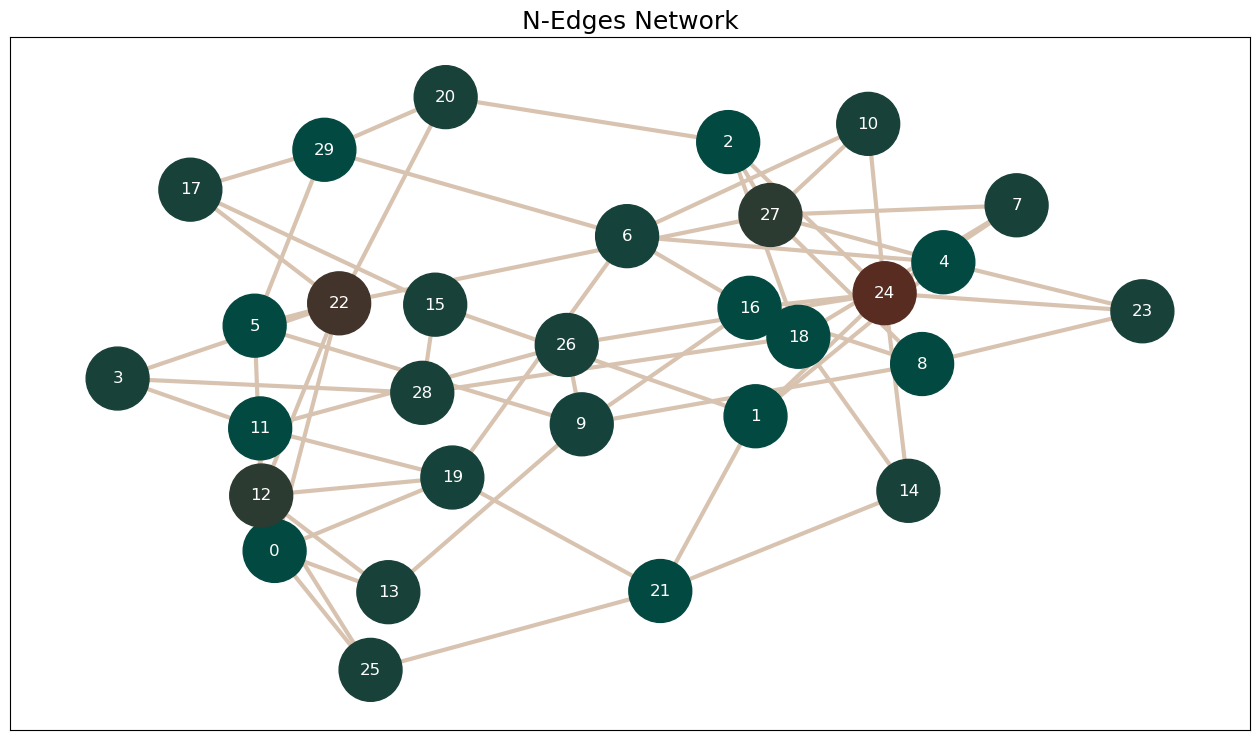

In [16]:
draw_ligand_network(network=nedges_network, title=nedges_network.name);

# Redundant MST

The `RedundantMinimalSpanningTreeNetworkGenerator` is an approach, that tries to increase the robustness over `Transformation` failures in an MST like network.
    
The algorithm executes the MST algorithm `n_redundancy` times, always removes already selected `Transformations` in each iteration, and finally builds the overlay of all the newtorks. 
This is constructing the Redundant MST Network. 

In this way the number of edges is increased, but also the network is less vulnerable to `Transformation` failures.


In [17]:
from konnektor.network_planners import RedundantMinimalSpanningTreeNetworkGenerator

ligand_network_planner = RedundantMinimalSpanningTreeNetworkGenerator(
    mapper=mapper, scorer=scorer, n_redundancy=2
)

In [18]:
rmst_network = ligand_network_planner(components)
rmst_network.name = "Redundant Min Spanning\n Tree Network"
rmst_network

<LigandNetwork-5d05c18c650529f21329845928630e39>

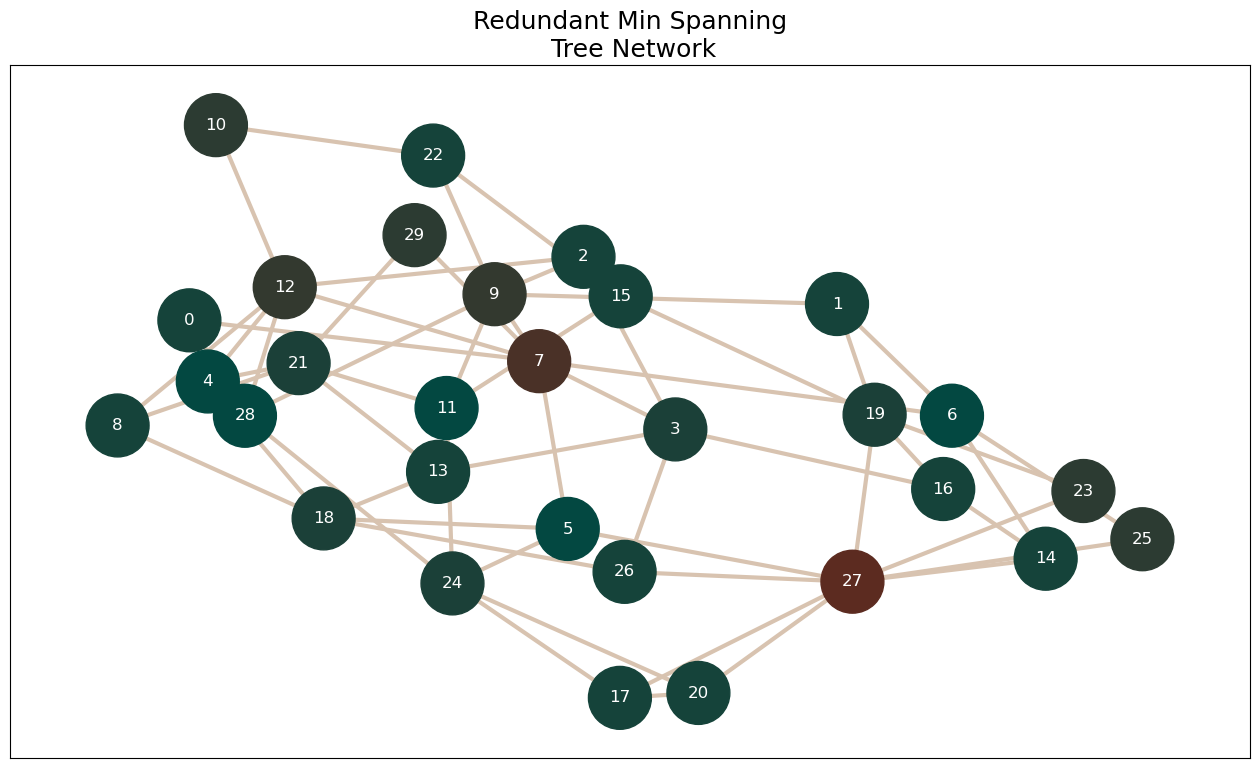

In [19]:
draw_ligand_network(network=rmst_network, title=rmst_network.name);

# Cyclic Network
The `CyclicNetworkGenerator` is generating a network based on many network cycles. T
his is of interest for analyzing the uncertainty of FE Estimates along the thermodynamic cycles and possibly correct the estimates with cycle closure analysis.

The greedy algorithm builds the network up from a nodewise perspective.
For each node, the algorithm generates all cycles of size `cycle_sizes` and assigns a score to each cylce as the sum of all sub-scores. 
Next it selects the `node_present_in_cyces` best score perfoming and node diversity increasing (see below) cycles per node.
The set of selected `Transformations` constructs the graph.
The node diversity criterion is an addition, which biases to spread the cycles on the graph eaqually between all `Components`
    
The number of cylces, around each `Component` can be defined by `component_present_in_cycles` and allowed cylce size can be tweaked with `cycle_sizes`. For `cycle_sizes` either an integer for providing an expected cycle size (e.g. `3`) or a range of allowed cycle sizes (e.g. `[3,4]`).

This layout has a well distributed connectivity between all `Component`s which increases the robustness very well, but still allows for a better graph score then the Twin Star Network, as the connectivity distribution is biased not enforced.
The large number of cycles might be very useful for statical analysis.  Nevertheless, the network has an increased amount of `Transformation`s  



In [20]:
from konnektor.network_planners import CyclicNetworkGenerator

ligand_network_planner = CyclicNetworkGenerator(
    mapper=mapper, scorer=scorer, cycle_sizes=[3, 4], node_present_in_cycles=2
)

In [21]:
cyclic_network = ligand_network_planner.generate_ligand_network(components)
cyclic_network.name = "Cyclic Network"
cyclic_network

<LigandNetwork-f180fb46d6d408ce23f668233ae70a3f>

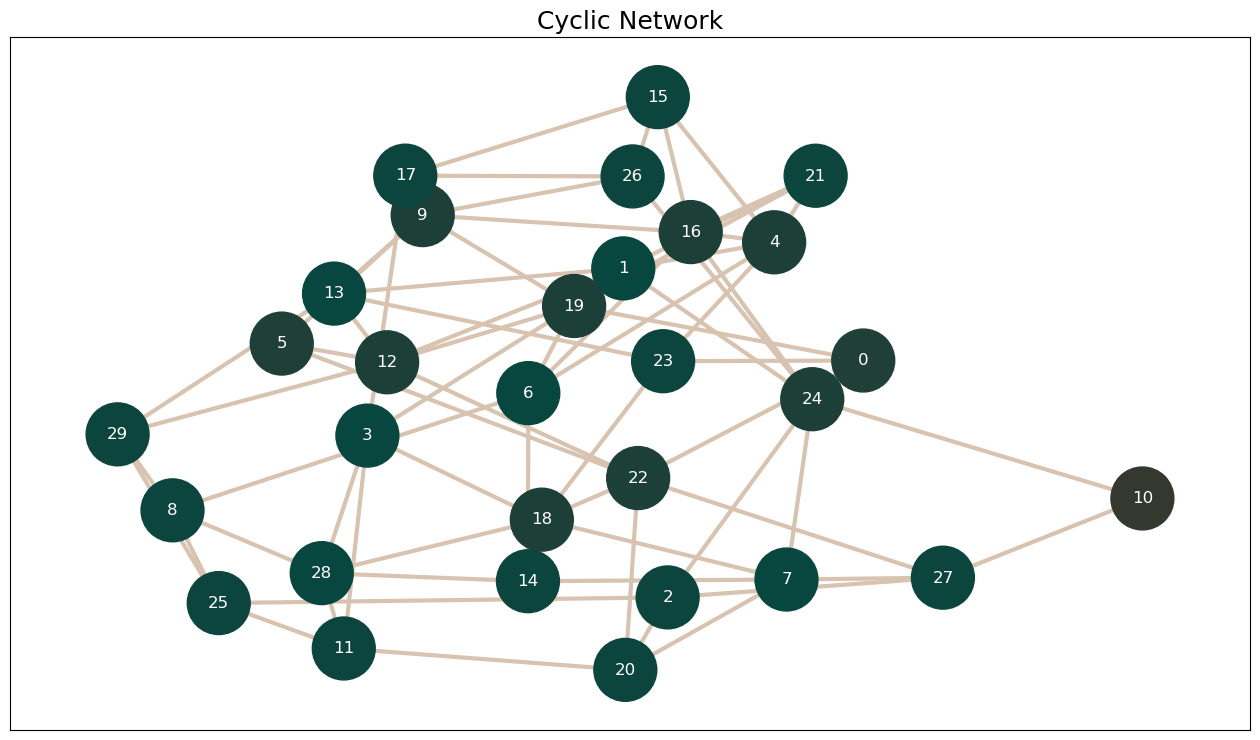

In [22]:
draw_ligand_network(network=cyclic_network, title=cyclic_network.name);

# Maximally connected network
The `MaximalNetworkGenerator` builds for given set of `Component`s a fully connected graph under the assumption each `Component` can be connected to another.
The `Transformation`s of this graph are realized as `AtomMapping`s of pairwise `Component`s. If not all mappings can be created, it will ignore the mapping failure, and return a nearly fully connected graph.

Note: This approach is not very suitable for Free Energy calculations in application cases. However, this approach is very important, as all above approaches use this as an initial solution, they filter down to gain the desired design.


This class is recommended as initial_edge_lister for other approaches.
> **Note**: the `MaximalNetworkGenerator` is parallelized and the number of CPUs can be given with  `n_processes`. 
> All other approaches in Konnektor benefit from this parallelization and you can use this parallelization with `n_processes` key word during class construction.


In [23]:
import logging
from konnektor.network_planners import MaximalNetworkGenerator
from kartograf.atom_mapper import logger

logger.setLevel(logging.ERROR)

ligand_network_planner = MaximalNetworkGenerator(
    mapper=mapper, scorer=scorer, n_processes=3
)

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [24]:
max_network = ligand_network_planner(components)
max_network.name = "Maximal Network"
max_network

<LigandNetwork-24e81c04325e18ab7e217c57b1f0b705>

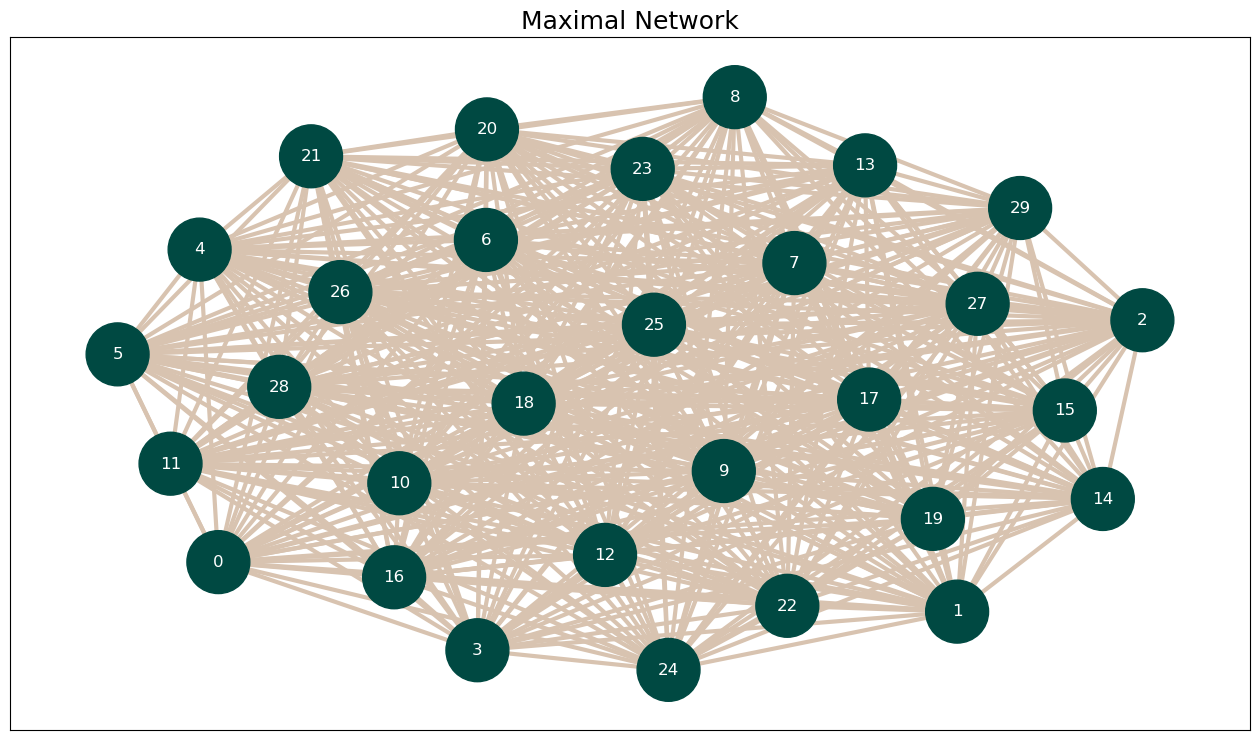

In [25]:
draw_ligand_network(network=max_network, title=max_network.name);

# Heuristic Maximal Network
The `HeuristicMaximalNetworkGenerator` builds for given set of `Component`s a set of `n_samples` `Transformation`s per `Component` build network under the assumption each `Component` can be connected to another.
The `Transformations` of this network are realized as `AtomMapping`s of pairwise `Component`s. If not all mappings can be created, it will ignore the mapping failure, and return a nearly fully connected graph.

This class is can be used as initial_edge_lister, if there is a large set of `Component`s (check network connectivity!)

This class is recommended as initial_edge_lister for other approaches.
> **Note**: the `HeuristicMaximalNetworkGenerator` is parallelized and the number of CPUs can be given with  `n_processes`. 
> All other approaches in Konnektor benefit from this parallelization and you can use this parallelization with `n_processes` key word during class construction.


In [26]:
import logging
from konnektor.network_planners import HeuristicMaximalNetworkGenerator
from kartograf.atom_mapper import logger

logger.setLevel(logging.ERROR)

ligand_network_planner = HeuristicMaximalNetworkGenerator(
    mapper=mapper,
    scorer=scorer,
    n_samples=10,
    n_processes=3,
)

In [27]:
hmax_network = ligand_network_planner(components)
hmax_network.name = "Heuristic Maximal\nNetwork"
hmax_network

<LigandNetwork-9dd695a1a20439b1ae85683c2d61f035>

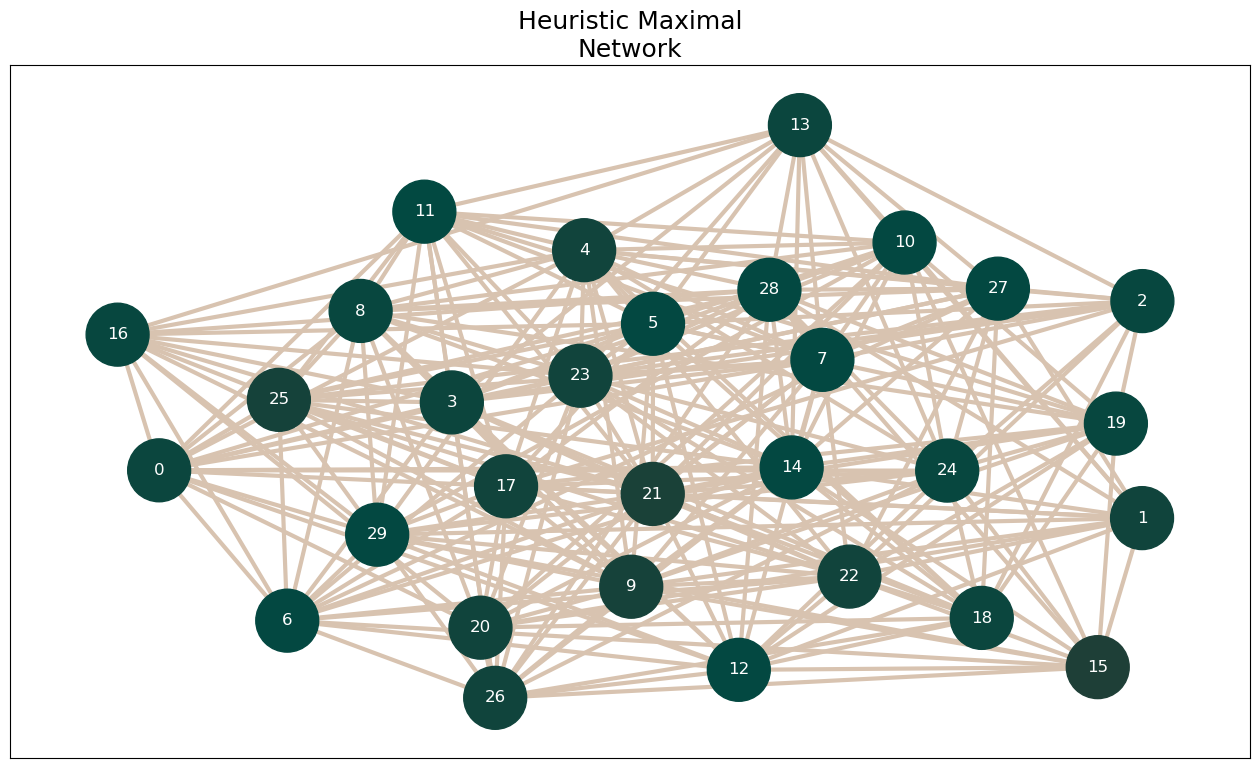

In [28]:
draw_ligand_network(network=hmax_network, title=hmax_network.name);

# Custom Diversity Cluster Network
This approach is the core of the Starry Sky. But now, it should be modified to use Cylic Networks instead of Star Networks. In the following you will learn how build up the network.

The `ClusteredNetworkGenerator` simply implements the following logic:
    1. Cluster `Component`s with the `clusterer` obj.
    2. Build sub-networks in the clusters using the `sub_network_planners`.
    3. Concatenate all sub-networks using the `concatenator` in order to build the final network.

In [29]:
from konnektor.network_planners import ClusteredNetworkGenerator
from konnektor.network_planners import CyclicNetworkGenerator
from konnektor.network_planners import MstConcatenator

sub_network_planner = CyclicNetworkGenerator(mapper=mapper, scorer=scorer)
network_concatenator = MstConcatenator(mapper=mapper, scorer=scorer)
ligand_network_planner = ClusteredNetworkGenerator(
    sub_network_planners=sub_network_planner, concatenator=network_concatenator
)

In [30]:
div_network = ligand_network_planner(components)
div_network.name = "Diversity Clustering\nNetwork"
div_network

ERR list index out of range


<LigandNetwork-ad8d74318824c282a696b4b2fd7fc12d>

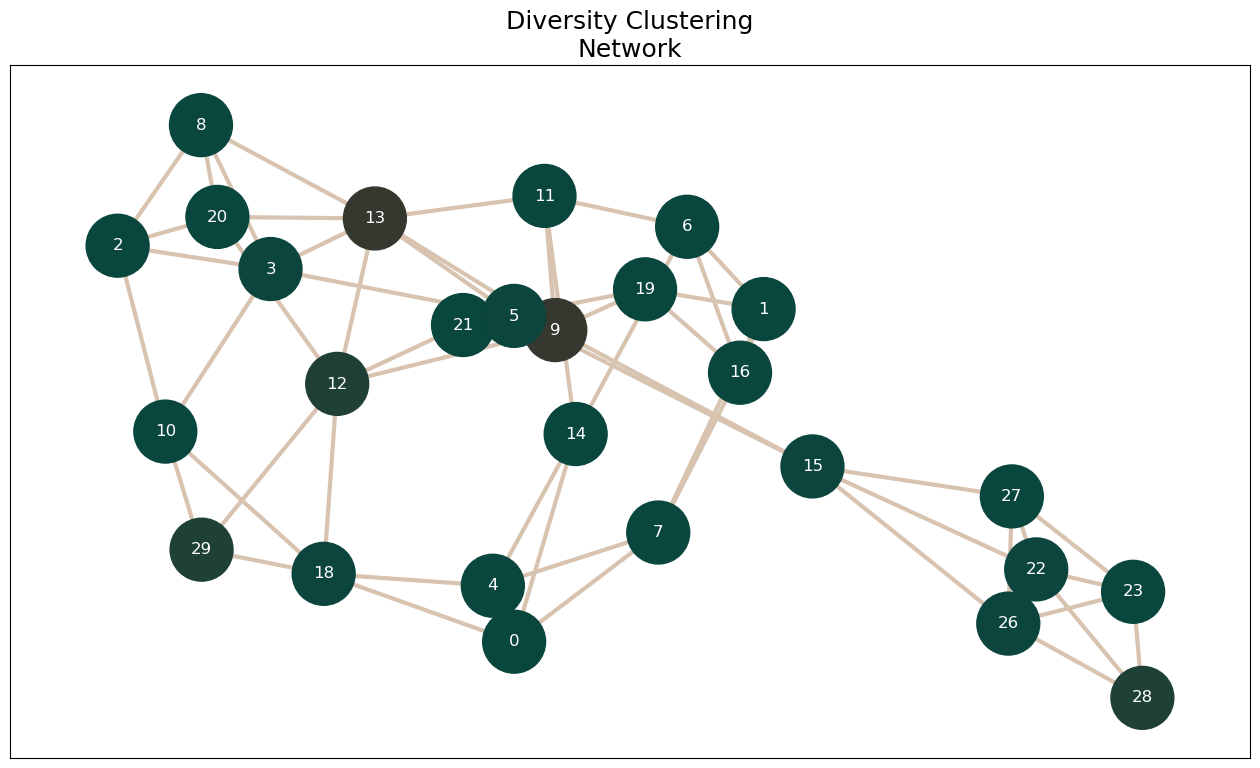

In [31]:
draw_ligand_network(network=div_network, title=div_network.name);

# Summary
Let's generate a nice summary figure, with all the shown network layouts.

NameError: name 'np' is not defined

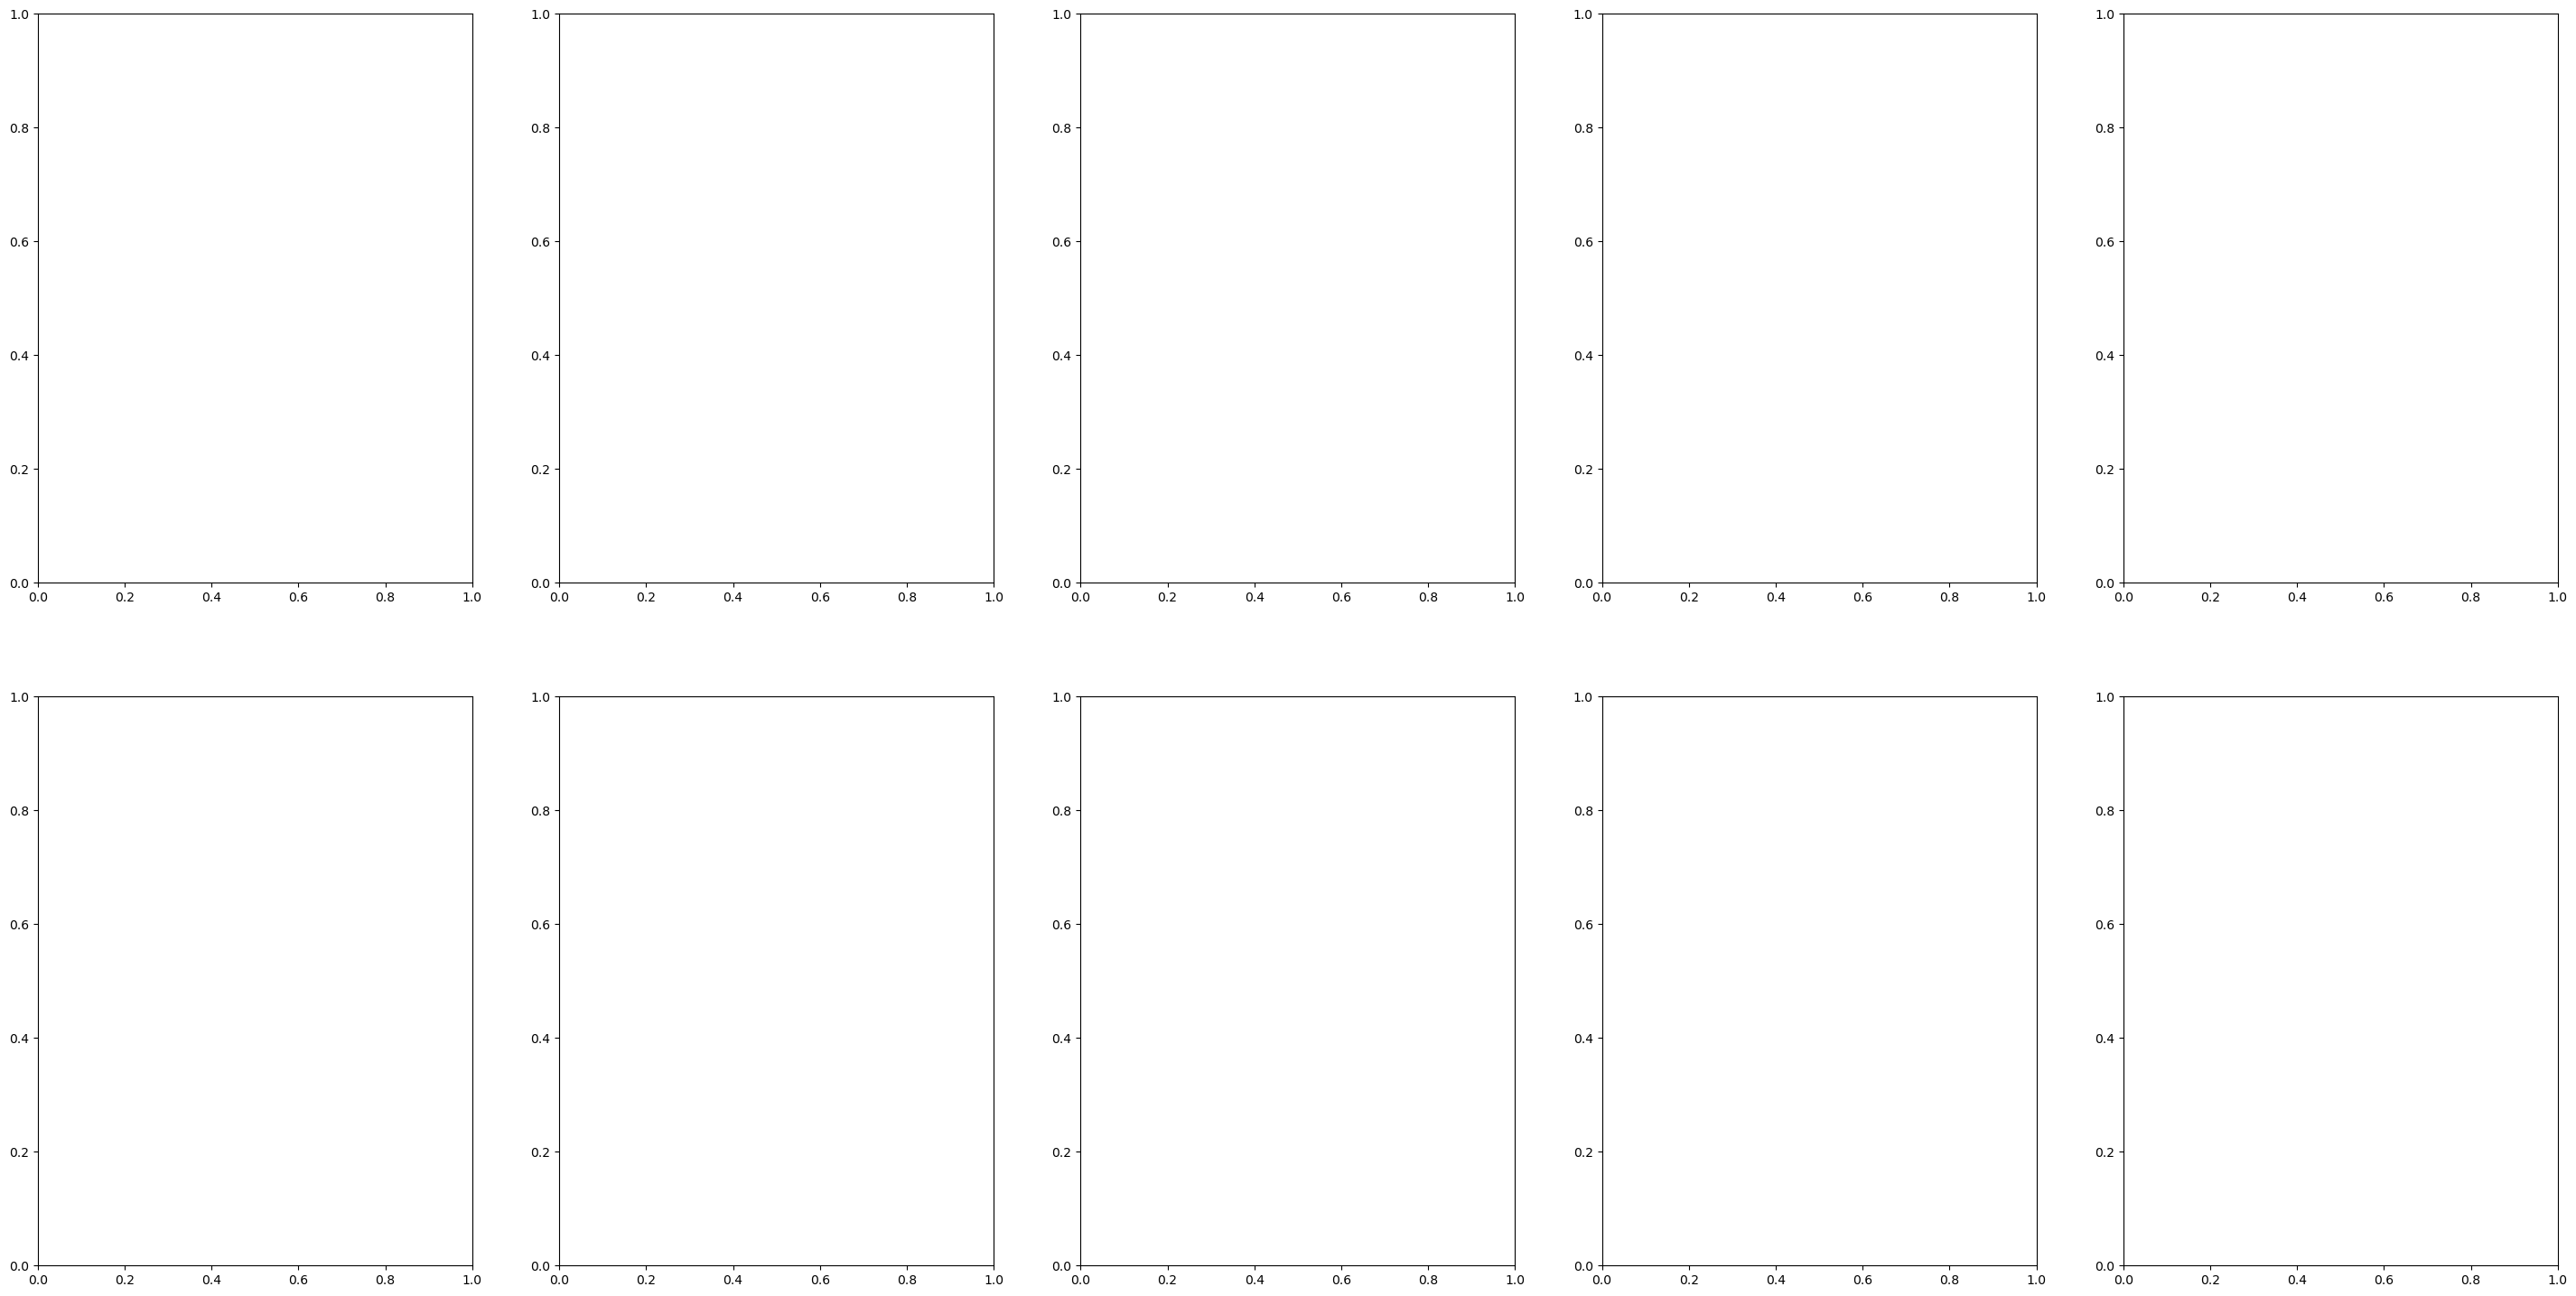

In [32]:
networks = [
    star_network,
    twin_star_network,
    starry_sky_network,
    nedges_network,
    rmst_network,
    cyclic_network,
    div_network,
    hmax_network,
    max_network,
]

networks = list(sorted(networks, key=lambda x: len(x.edges)))

import numpy as np
from matplotlib import pyplot as plt

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=[9 * 4, 2 * 9])
axes = np.array(axes).flat
fs = 22
for ax, net in zip(axes, networks):
    draw_ligand_network(network=net, title=net.name, ax=ax, node_size=1500, fontsize=40)
    ax.axis("off")
axes[-1].axis("off")
fig.tight_layout()

In [ ]:
# NBVAL_SKIP
fig.savefig("./network_layouts.png", dpi=400)